### CNN for ECG signal classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

## CNN architecture design

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256,kernel_size=2)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(256, 256,2,2)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(num_features=256)
        self.conv3 = nn.Conv1d(256, 256,2,2)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(num_features=256)
        self.conv4 = nn.Conv1d(256, 256,2,2)
        self.bn5 = nn.BatchNorm1d(num_features=256)
        self.conv5 = nn.Conv1d(256, 256,2,2)
        
        self.fc1 = nn.Linear(in_features=2816, out_features=2816)
        self.fc2 = nn.Linear(in_features=2816, out_features=5)
        
    def forward(self, x):
        print(x.size())
       
        y=self.conv1(x)
        y=nnF.relu(y)
        print('conv relu1',y.shape)
        
        pool_1=self.pool1(y)
        y=self.conv2(y)
        y=nnF.relu(y)
        print('conv relu2',y.shape,'pool1',pool_1.shape)
        y=y+pool_1
        
        pool_2=self.pool2(y)
        y=self.conv3(self.bn3(y))
        y=nnF.relu(y)
        print('conv relu3',y.shape,'pool2',pool_2.shape)
        y=y+pool_2
    
        
        pool_3=self.pool3(y)
        y=self.conv4(self.bn4(y))
        y=nnF.relu(y)
        print('conv relu4',y.shape,'pool3',pool_2.shape)
        y=y+pool_3
        
        y=self.conv5(self.bn5(y))
        y=nnF.relu(y)
        print('conv relu4',y.shape)
        
        y = y.view(y.size(0), -1)
        print('!!',y.size())
        
        y=self.fc1(y)
        y=nnF.relu(y)
        print('!!',y.size())
        
        z=self.fc2(y)
        print('!!',z.size())

        return z

In [3]:
#Check dimensions of output of each layer to make sure it matches up 
model=Net()
x=torch.rand(1,1,187)
z=model(x)

torch.Size([1, 1, 187])
conv relu1 torch.Size([1, 256, 186])
conv relu2 torch.Size([1, 256, 93]) pool1 torch.Size([1, 256, 93])
conv relu3 torch.Size([1, 256, 46]) pool2 torch.Size([1, 256, 46])
conv relu4 torch.Size([1, 256, 23]) pool3 torch.Size([1, 256, 46])
conv relu4 torch.Size([1, 256, 11])
!! torch.Size([1, 2816])
!! torch.Size([1, 2816])
!! torch.Size([1, 5])


In [4]:
def cal_accuracy(confusion):
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

In [23]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

## Function to train CNN model

In [5]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()
    loss_train=0
    acc_train =0 
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Z = model(X)
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()
        optimizer.step()
        loss_train+=loss.item()
        Yp = Z.data.max(dim=1)[1]               
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=sample_count    
    return loss_train, acc_train

## Function to test CNN

In [6]:
def test(model, device, dataloader):
    model.eval()
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad():
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)
            Yp = Z.data.max(dim=1)[1]  
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Data

In [7]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):        
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        x=x.reshape(1,-1) 
        return x, y

In [8]:
import pandas as pd
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [9]:
X=X.values
X.shape

(3841, 187)

In [10]:
Y=Y.values
Y.shape

(3841, 1)

In [11]:
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

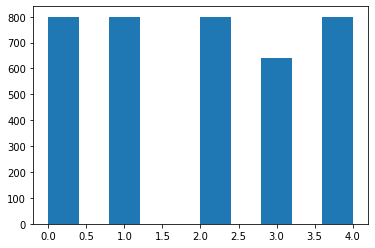

In [12]:
plt.hist(Y)

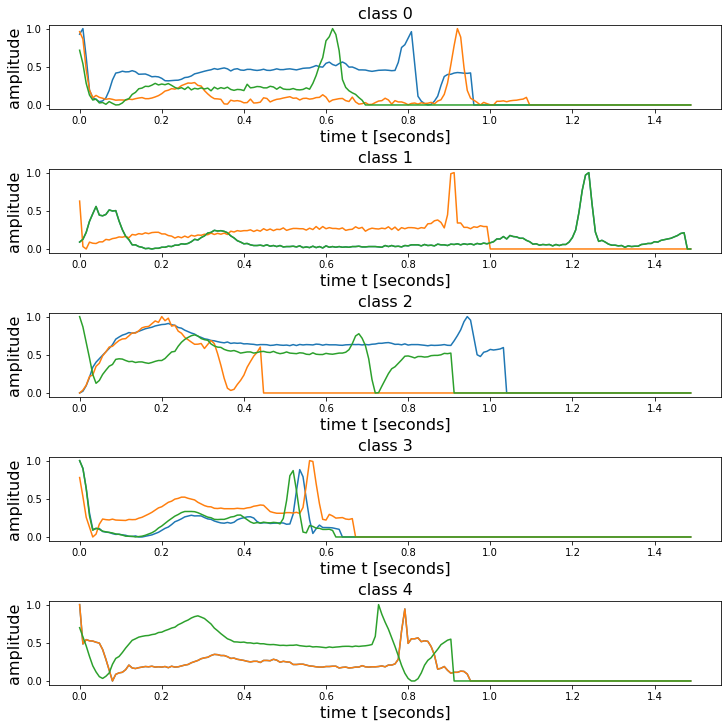

In [13]:
fs=125  
Ts=1/fs 
N=187 
Duration=N*Ts 
t=np.linspace(0, Duration-Ts, N)
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

## Train Val Test split convert to torch

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

x=dataset_train
x[0][0].size()

## Initialise CNN and tell program to calculate on gpu if have access to one

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
x=dataset_train[0][0]
x=x.view(1,1,187).to(device)
z=model(x)

torch.Size([1, 1, 187])
conv relu1 torch.Size([1, 256, 186])
conv relu2 torch.Size([1, 256, 93]) pool1 torch.Size([1, 256, 93])
conv relu3 torch.Size([1, 256, 46]) pool2 torch.Size([1, 256, 46])
conv relu4 torch.Size([1, 256, 23]) pool3 torch.Size([1, 256, 46])
conv relu4 torch.Size([1, 256, 11])
!! torch.Size([1, 2816])
!! torch.Size([1, 2816])
!! torch.Size([1, 5])


In [19]:
y_hat=nnF.softmax(z, dim=1)
y_hat

tensor([[0.2012, 0.1870, 0.2227, 0.1881, 0.2009]], grad_fn=<SoftmaxBackward0>)

In [20]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [21]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

## Train and graph loss and accuracy for training and validation set

In [ ]:
for epoch in range(epoch_save+1, 100): 
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
 
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)

    result = (loss_train_list, acc_train_list, 
              acc_val_list, other_val)
    save_checkpoint('ECG_CNN_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

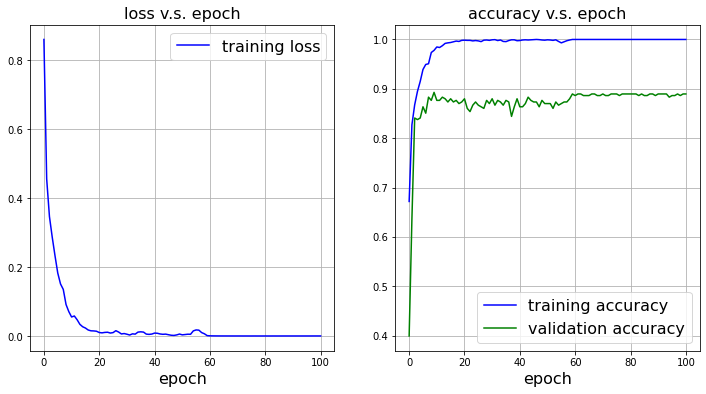

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

### Use optimised number of epochs for our CNN as seen in above graph

In [26]:
best_epoch=np.argmax(acc_val_list)
best_epoch

9

In [28]:
checkpoint=torch.load('ECG_CNN_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

In [29]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

torch.Size([128, 1, 187])
conv relu1 torch.Size([128, 256, 186])
conv relu2 torch.Size([128, 256, 93]) pool1 torch.Size([128, 256, 93])
conv relu3 torch.Size([128, 256, 46]) pool2 torch.Size([128, 256, 46])
conv relu4 torch.Size([128, 256, 23]) pool3 torch.Size([128, 256, 46])
conv relu4 torch.Size([128, 256, 11])
!! torch.Size([128, 2816])
!! torch.Size([128, 2816])
!! torch.Size([128, 5])
torch.Size([128, 1, 187])
conv relu1 torch.Size([128, 256, 186])
conv relu2 torch.Size([128, 256, 93]) pool1 torch.Size([128, 256, 93])
conv relu3 torch.Size([128, 256, 46]) pool2 torch.Size([128, 256, 46])
conv relu4 torch.Size([128, 256, 23]) pool3 torch.Size([128, 256, 46])
conv relu4 torch.Size([128, 256, 11])
!! torch.Size([128, 2816])
!! torch.Size([128, 2816])
!! torch.Size([128, 5])
torch.Size([128, 1, 187])
conv relu1 torch.Size([128, 256, 186])
conv relu2 torch.Size([128, 256, 93]) pool1 torch.Size([128, 256, 93])
conv relu3 torch.Size([128, 256, 46]) pool2 torch.Size([128, 256, 46])
conv 